In [1]:
import os
import platform
import sys
import requests
import json
import operator
import time
import datetime
import nltk
import matplotlib
import matplotlib.pyplot as pyplot

if platform.system() == 'Windows':
    if not os.path.exists('..\\output'):
        os.makedirs('..\\output')   
else:
    if not os.path.exists('../output/'):
        os.makedirs('../output/')
    
print(datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'))
print('_______________________________________________')

2018-10-14 11:53:01
_______________________________________________


In [2]:
from nltk import ngrams, FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mantasbandonis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mantasbandonis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
def writeText(text, path, mode = 'a'):
    with open (path, mode) as textout:
        textout.write((text))
        
def writeJson(json, path, mode = 'w'):
    with open(path, mode) as file:
        file.write(json.dumps(json))
        
def writeCsv(listOut, outputFile):
    import csv
    with open (outputFile, "w", newline='') as outputfile:
        writer = csv.writer(outputfile, delimiter = ",")
        for element in listOut:
            writer.writerow(element)

def getTxt(path):
    return open(path, 'r').read()

In [4]:
def getToken():
    if platform.system() == 'Windows':
        return open('..\\token\\token.txt', 'r').read()
    else:
        return open('../token/token.txt', 'r').read()

In [5]:
def getJsonDocs(page = 1, itemsperpage = 200):
    jsondata ='dummy'
    list_return = []

    while jsondata:
        try:
            r = requests.get("https://app.23degrees.io/services/pub/api/v1/opendata/getWorldBankDataSetsPaginated/"+str(page)+"/"+str(itemsperpage)
                         ,timeout=None
                         ,headers={  'Content-Type': 'application/json'
                                    , 'Authorization' : 'Bearer '+ getToken()
                                   }
                        )    
            jsondata = r.json()
            for elem in jsondata:
                list_return.append(elem)
        except requests.exceptions.HTTPError as err:
            print(err)
        page += 1
    return list_return

In [6]:
def getFeaturesLabels(list_in):
    list_return = []
    for elem in list_in:
        list_inner = []
        list_inner.append(elem[1])
        list_inner.append(elem[2])
        list_inner.append(elem[3])
        list_return.append(list_inner)
    return list_return

In [7]:
list_js_docs = getJsonDocs(1,200)

In [8]:
list_list_js_tags = [] #Format: jsondoc(str)|name(str)|description(str)|tags(list)
list_js_tags_inner = []
list_js_notags = []
list_unique_tags = []
list_tags = []
dict_tags = {}
for i, jsondoc in enumerate(list_js_docs):
    jstmp = json.dumps(jsondoc, sort_keys=True,indent=4, separators=(',', ': '))
    if 'tags' in jstmp:
        list_js_tags_inner = []
        list_js_tags_inner.append(jstmp)
        tmp_list_tags = []
        for tag in jsondoc['typeSpecific']['context']['tags']:
            tmp_list_tags.append(tag)
            list_tags.append(tag)
            if tag not in list_unique_tags:
                list_unique_tags.append(tag)
                dict_tags[tag] = 1
            else:
                dict_tags[tag] += 1
        list_js_tags_inner.append(jsondoc['name'])
        list_js_tags_inner.append(jsondoc['description'])
        list_js_tags_inner.append(tmp_list_tags)
        list_list_js_tags.append(list_js_tags_inner)
                
    else:
        list_js_notags.append(jstmp)

In [9]:
list_tags_sorted = list(sorted(dict_tags.items(), key=lambda x: x[1], reverse = True))
ll_name_desc_tags = getFeaturesLabels(list_list_js_tags)

In [10]:
print('Json-Files: ', len(list_js_docs))
print('Json-Files with tags: ', len(list_list_js_tags))
print('Json-Files without tags: ', len(list_js_notags))
print('Unique tags: ', len(list_tags_sorted))

Json-Files:  4580
Json-Files with tags:  3573
Json-Files without tags:  1007
Unique tags:  2848


In [11]:
fdist_total_tags = FreqDist(list_tags)
fdist_total_tags.most_common(5)

[('World Bank', 3553),
 ('Business_Finance', 2174),
 ('Economy', 1992),
 ('Social Issues', 890),
 ('Money', 691)]

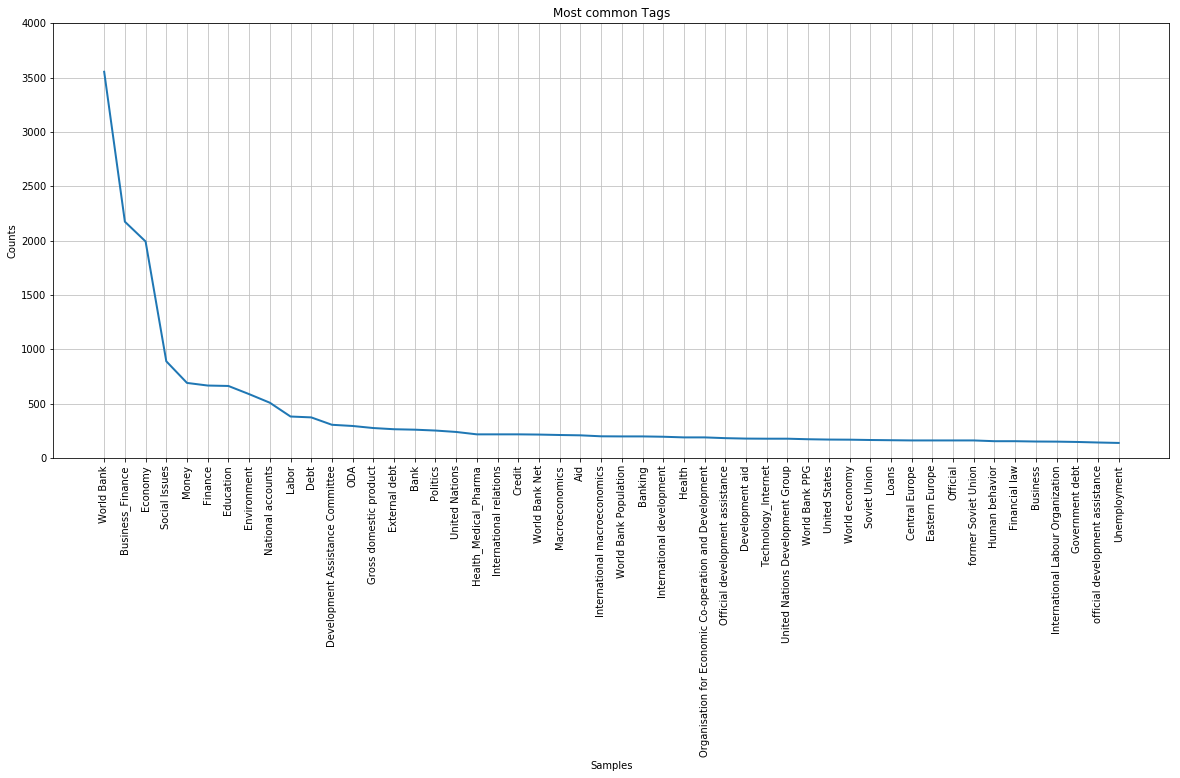

In [12]:
pyplot.figure(figsize=(20, 8))
pyplot.ylim(0, 4000)
fdist_total_tags.plot(50, title = 'Most common Tags')

### Which tags should be ignored?

Only tags appearing less than 1000 times?

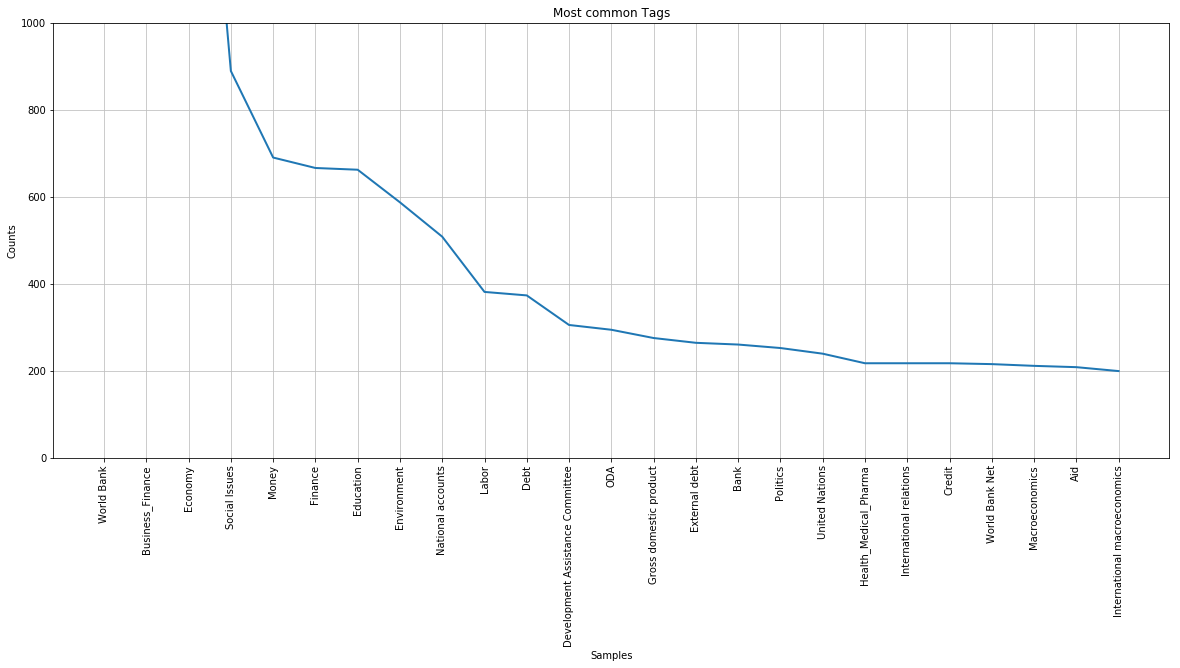

In [13]:
pyplot.figure(figsize=(20, 8))
pyplot.ylim(0, 1000)
fdist_total_tags.plot(25, title = 'Most common Tags')

* excluding first 3 tags
* assumption: take the first 200 most common tags

In [14]:
def chooseTags(list_tags,first,topx):
    list_chosen = []
    list_notchosen = []
    for i, elem in enumerate(list_tags):
        if (i > first) & (i < (topx+first+1)):
            list_chosen.append(elem[0])   
        else:
            list_notchosen.append(elem[0]) 
        
    return list_chosen, list_notchosen

In [15]:
list_chosen_tags = chooseTags(list_tags_sorted,2,200)

### Removing not used tags and fillerwords from name and describtion:

In [16]:
list_fillerwords = getTxt('../input/fillerwords.txt').split(',') + stopwords.words('english')

In [17]:
for i, elements in enumerate(ll_name_desc_tags):
    for tags in list_chosen_tags[1]:
        while (tag in ll_name_desc_tags[i][2]):
            ll_name_desc_tags[i][2].remove(tag) 

In [18]:
porterstemmer = PorterStemmer()
for i, elem in enumerate(ll_name_desc_tags):
    ll_name_desc_tags[i][0] = nltk.word_tokenize(''.join([x for x in elem[0] if not x.isdigit()]).replace('.','').replace(',','').replace('%','').replace('(','').replace(')',''))
    for word in list_fillerwords:
        while (word in ll_name_desc_tags[i][0]):
            ll_name_desc_tags[i][0].remove(word)
    for j, word in enumerate(ll_name_desc_tags[i][0]):
        ll_name_desc_tags[i][0][j] = ll_name_desc_tags[i][0][j].lower()
        porterstemmer.stem(ll_name_desc_tags[i][0][j])
            
    ll_name_desc_tags[i][1] = nltk.word_tokenize(''.join([x for x in elem[1] if not x.isdigit()]).replace('.','').replace(',','').replace('%','').replace('(','').replace(')',''))
    for word in list_fillerwords:
        while (word in ll_name_desc_tags[i][1]):
            ll_name_desc_tags[i][1].remove(word)
    for j, word in enumerate(ll_name_desc_tags[i][1]):
        ll_name_desc_tags[i][1][j] = ll_name_desc_tags[i][1][j].lower()
        porterstemmer.stem(ll_name_desc_tags[i][1][j])
        
    for j, word in enumerate(ll_name_desc_tags[i][2]):
        ll_name_desc_tags[i][2][j] = ll_name_desc_tags[i][2][j].lower()
        porterstemmer.stem(ll_name_desc_tags[i][2][j])

In [19]:
if platform.system() == 'Windows':
    writeCsv(ll_name_desc_tags, '..\\output\\prep_out.csv')
else:
    writeCsv(ll_name_desc_tags, '../output/prep_out.csv')

In [20]:
print(datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'))
print('_______________________________________________')

2018-10-14 11:53:27
_______________________________________________


In [22]:
ll_name_desc_tags[10]

[['external',
  'health',
  'expenditure',
  'capita',
  'ppp',
  'current',
  'international',
  '$',
  'countries',
  'grouped',
  'income',
  'levels'],
 ['current',
  'external',
  'expenditures',
  'health',
  'capita',
  'expressed',
  'international',
  'dollars',
  'purchasing',
  'power',
  'parity',
  'ppp',
  'external',
  'sources',
  'composed',
  'direct',
  'foreign',
  'transfers',
  'foreign',
  'transfers',
  'distributed',
  'government',
  'encompassing',
  'financial',
  'inflows',
  'national',
  'health',
  'outside',
  'country'],
 ['business_finance',
  'economy',
  'purchasing power',
  'gross domestic product',
  'currency',
  'inequalities',
  'purchasing power parity',
  'trade',
  'geary–khamis dollar',
  'international comparison program',
  'world bank external']]

In [23]:
lemmatized_words2 =[]
lemmatizer = nltk.WordNetLemmatizer()
for sub_list in ll_name_desc_tags:
    for sub_list2 in sub_list:
        for value in sub_list2:
            lemmatized_words = lemmatizer.lemmatize(value)
            lemmatized_words2.append(lemmatized_words)
print(lemmatized_words2)

['domestic', 'general', 'government', 'health', 'expenditure', 'caput', 'current', 'u', '$', 'country', 'public', 'expenditure', 'health', 'domestic', 'source', 'caput', 'expressed', 'current', 'u', 'dollar', 'social issues', 'politics', 'business_finance', 'environment', 'economy', 'national accounts', 'health systems by country', 'military budget', 'world bank domestic', 'domestic', 'general', 'government', 'health', 'expenditure', 'caput', 'current', 'u', '$', 'world', 'region', 'public', 'expenditure', 'health', 'domestic', 'source', 'caput', 'expressed', 'current', 'u', 'dollar', 'social issues', 'environment', 'business_finance', 'politics', 'economy', 'national accounts', 'health systems by country', 'military budget', 'world bank domestic', 'domestic', 'general', 'government', 'health', 'expenditure', 'caput', 'current', 'u', '$', 'world', 'public', 'expenditure', 'health', 'domestic', 'source', 'caput', 'expressed', 'current', 'u', 'dollar', 'social issues', 'business_finance'